# Lego Deffect Detection

## Inicialização do Ambiente

In [1]:
# Recarregamento automático das libs carregadas após elas serem modificadas.
%load_ext autoreload
%autoreload 2

In [2]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.filters import (threshold_otsu, threshold_triangle, threshold_niblack, threshold_sauvola)
from skimage import img_as_ubyte
from IPython.display import display, Image

In [3]:
from utils import *
from preprocess import *
from pipeline import Pipeline

In [4]:
# Config de diretórios.
path_train_csv = "lego-deffect-detection/train.csv"
path_data = "lego-deffect-detection/lego"

# Para a saída de floats do Numpy.
# np.set_printoptions(precision=10, suppress=False)
# Desativado pois os valores de alguns momentos Hu saíram tão pequenos que precisaram da notação científica.

In [5]:
# Carregar caminhos dos arquivos e as imagens em escala de cinza pra dentro do dataframe inicial.

df = pd.read_csv(path_train_csv)

df["img_src"] = None
df["img_path"] = None

for i in range(len(df)):
    file_name = df.at[i, "example_id"]
    file_name += ".jpg"
    img_path = os.path.join(path_data, file_name)
    df.at[i, "img_path"] = img_path
    df.at[i, "img_src"] = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

df.head()

example_id  has_deffect  no_hat  no_face  no_head  no_leg  no_body  no_hand  \
0  adsyjmgvp            0       0        0        0       0        0        0   
1  agmpdjsyv            1       1        1        0       1        0        0   
2  ajgyvdsmp            0       0        0        0       0        0        0   
3  ajsdmvypg            0       0        0        0       0        0        0   
4  apmjvdgys            0       0        0        0       0        0        0   

   no_arm                                            img_src  \
0       0  [[57, 60, 63, 62, 59, 57, 58, 59, 58, 57, 55, ...   
1       0  [[52, 51, 49, 48, 47, 48, 49, 50, 53, 52, 50, ...   
2       0  [[60, 60, 64, 65, 58, 49, 51, 59, 61, 59, 57, ...   
3       0  [[66, 64, 62, 59, 58, 59, 60, 61, 64, 63, 61, ...   
4       0  [[54, 53, 54, 55, 51, 47, 49, 55, 51, 49, 46, ...   

                                    img_path  
0  lego-deffect-detection/lego/adsyjmgvp.jpg  
1  lego-deffect-detection/lego/agmpdjsyv.jpg  
2  lego-deffect-detection/lego/ajgyvdsmp.jpg  
3  lego-deffect-detection/lego/ajsdmvypg.jpg  
4  lego-deffect-detection/lego/apmjvdgys.jpg

5 (288, 352)
D.Type: <class 'numpy.uint8'>     Img.Shape: (288, 352)     5 imgs


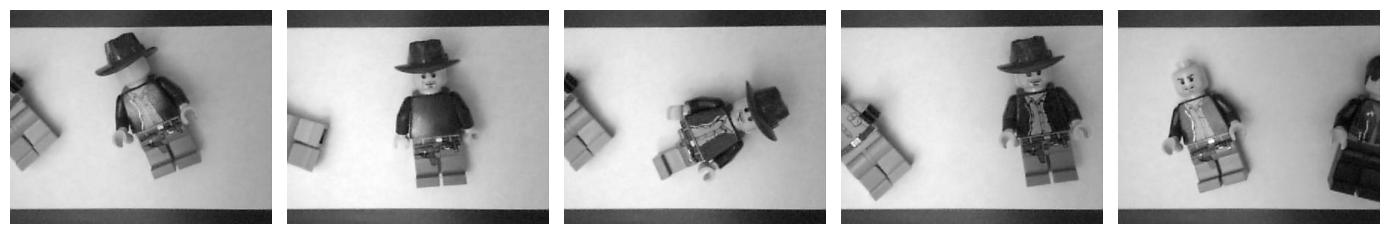

In [6]:
# Uma olhada nas imagens carregadas.

# Escolher tamanho da amostra e quantidade razoáveis de colunas.
n_sample = 5

# Extrai uma amostra aleatória.
# Dataframe.sample() retorna uma série do Pandas, não lista.
# Por isso usamos .tolist()
sample = df["img_src"].sample(n=n_sample).tolist()

# Exibe amostra.
print(n_sample, sample[0].shape)
implotmany(sample, n_cols=5)

### Pipeline

Usamos uma classe definida em pipeline.py para organizar o fluxo das etapas da execução. Sua estrutura se resume ao seguinte:

```python
# Lista de imagens a serem operadas é fornecida na criação. São copiadas para dentro do objeto Pipeline.
P = Pipeline(src: list)

# Cada chamada a add_preproc() enfileira uma nova etapa no pipeline.
P.add_preproc(funct_name, *args, **kwargs)

# Executa as etapas do pipeline na ordem em que foram adicionadas, passando o resultado de cada etapa/função
P.run()  # para a etapa/função seguinte.

# Exibe o resultado do pipeline.
P.plot_data()
```

Uma etapa no pipeline pode operar em cima o resultado da imagem recebida pela etapa anterior do pipeline,
ou também consultar a imagem original para efetuar alguma coisa com base nela.  
A segunite função serve pra demonstrar como fazer uma etapa que usa a lista de imagens da etapa anterior
e também consulta as imagens originais:

```python
def do_something(data, src=None):
    print(src)
    return [img*0.5 for img in data]

P = Pipeline(src=sample)
P.add_process(test_shit, use_src=True)
```

Quando `use_src` é omitido, o pipeline não entrega `self.src` para o processo.
Mas se for incluido `use_src=True`, o pipeline vai pasar `src=self.src` para a função na sua chamada.

É necessário `src=None` da definição da função, ou vai ter erro de 'argumentos faltando/insuficientes' quando src não for usada.

## Pipeline 1 - Isolar Bonecos

Vamos iterar sobre cada imagem e recortar dela o boneco pra analizar.

Usamos a classe Pipeline mencionada anteriormente pra isso.

In [7]:
# Cria pipeline com imagens fonte.
P1 = Pipeline( src=df["img_src"].tolist() )

# threshold_method : otsu niblack sauvola triangle
P1.add_preproc(binarize, threshold_method="otsu")

# Nas imagens originais, o fundo é branco. Invertemos pra poder usar branco como objeto e preto como fundo.
P1.add_preproc(inverse)

# Detecta as bordas da mesa e as remove da imagem binarizada, pra não interferir com as próximas etapas.
P1.add_preproc(remove_table_borders)

# Fechamento para formar massas conexas de pixels com a imagem binarizada.
P1.add_preproc(morph_closing, kernel_size=9)

# Em geral, aqui está o problema ocasional de selecionar o lego errado na mesa. Tem umas 5 ocorrências
P1.add_preproc(isolate_highest_area_conn_comp)  # desse erro, na base de testes.

# Funcionou melhor do que usar o casco convexo, cortando menos das bordas dos bonecos. Contudo, ainda
P1.add_preproc(rectangle_hull)  # esté sendo cortado parte da cabeã de bonecos carecas e das mãos brancas.

# Erros observados nessa etapa foram consequências de isolate_highest_area_conn_comp() e rectangle_hull().
P1.add_preproc(extract_by_mask, use_src=True)  # Usamos as máscaras construídas para isolar os bonecos.


# Executa pipeline construida.
P1.run()

D.Type: <class 'numpy.uint8'>     Img.Shape: (212, 114)     90 imgs


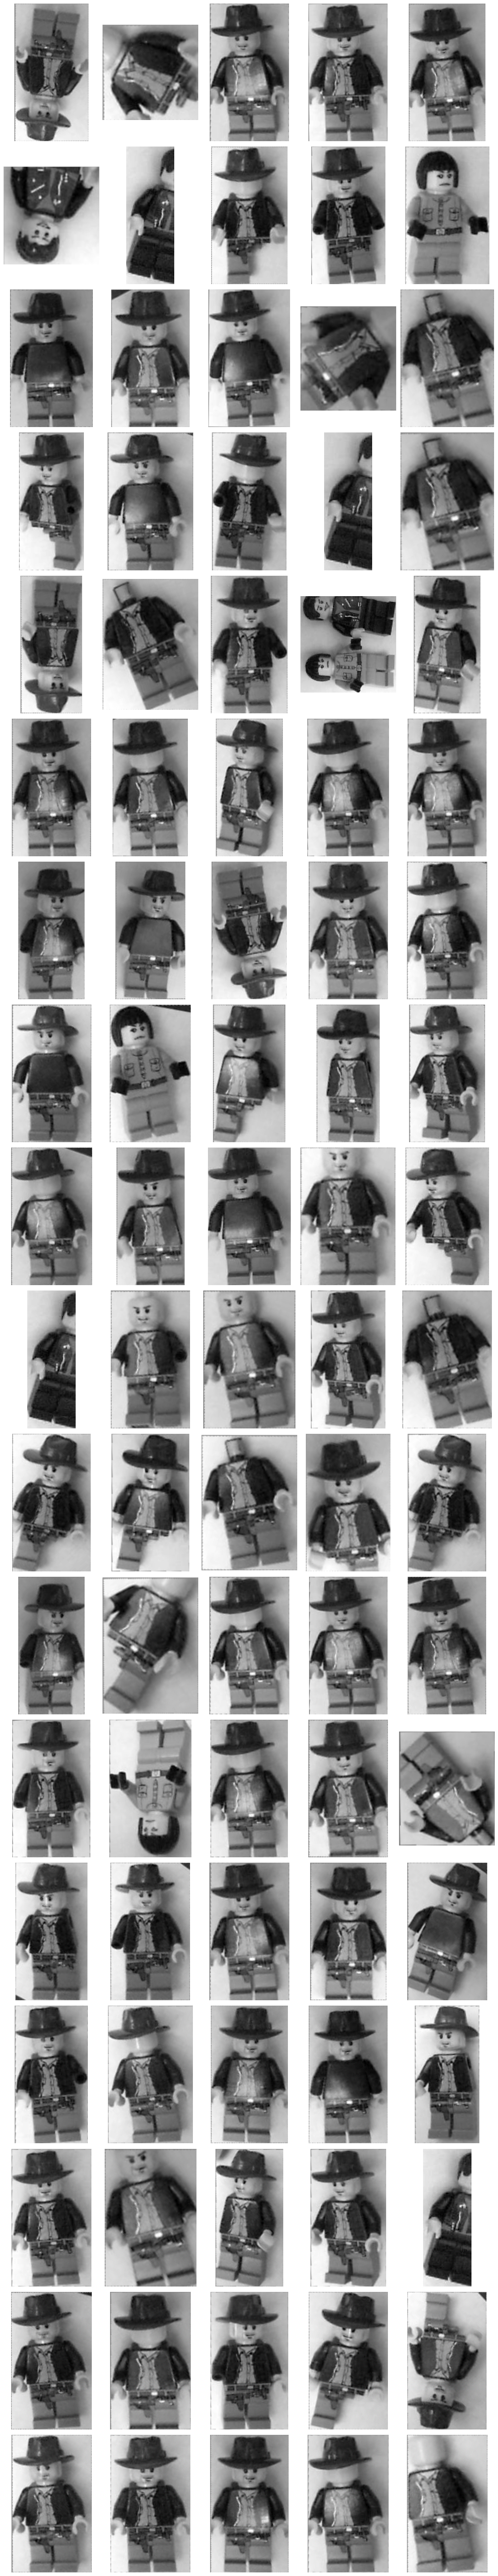

In [8]:
# Exibe estado da execução da pipeline.
P1.plot_data(n_cols=5)

## Pipeline 2 - Extrair Características

Vamos usar os bonecos isolados para extrair características dos bonecos descritos em cada imagem.

Para esse fim vamos usar outro Pipeline.

In [28]:
def feature_extract(imset: list, src=None):
    print(len(src))


    feature_set = []

    for img in imset:
        
        contours, hierarchy = cv.findContours(img, mode=cv.RETR_LIST, method=cv.CHAIN_APPROX_TC89_KCOS)
        moments = cv.moments(img, binaryImage=True)
        hu_moments = cv.HuMoments(moments)

        feature_set.append((contours, moments, hu_moments))

    for features in feature_set:
        contours, moments, hu_moments = features
        print("contours: ", len(contours))
        print("moments: ", moments)
        print("hu_moments: ", hu_moments)
        print()
    
    return imset

In [29]:
# Novo pipeline com o resultado do pipeline 1.
P2 = Pipeline(src=P1.data)



# Agora as máscaras binárias serão muito melhores, ao usar thresholding local ou dinâmico.
P2.add_preproc(binarize, threshold_method="otsu")

# Inverter preto e branco, pos branco é o objeto nos algoritmos do OpenCV.
P2.add_preproc(inverse)

# Fechamento.
P2.add_preproc(morph_closing, kernel_size=3)

# Abertura.
P2.add_preproc(morph_opening, kernel_size=3)

# Extração de características das imagens binarizadas.
P2.add_preproc(feature_extract, use_src=True)



# Roda novo pipeline.
P2.run()

# Exibe estado interno do processo.
# P2.plot_data(n_cols=5)

90
contours:  7
moments:  {'m00': 12935.0, 'm10': 695902.0, 'm01': 1300689.0, 'm20': 44569508.0, 'm11': 66002869.0, 'm02': 168001165.0, 'm30': 3168102964.0, 'm21': 4051558467.0, 'm12': 8168139957.0, 'm03': 24875301687.0, 'mu20': 7130034.199922696, 'mu11': -3974098.644221097, 'mu02': 37209369.505527645, 'mu30': 3076301.78081131, 'mu21': -2550725.237379074, 'mu12': -71072562.74668741, 'mu03': 498579419.6451111, 'nu20': 0.042614632437395536, 'nu11': -0.02375230584381631, 'nu02': 0.22239214570983215, 'nu30': 0.0001616638265536151, 'nu21': -0.00013404406711126633, 'nu12': -0.003734959466028456, 'nu03': 0.026201024009891563}
hu_moments:  [[ 2.65006778e-01]
 [ 3.45766424e-02]
 [ 8.36926203e-04]
 [ 6.92255885e-04]
 [ 5.26912292e-07]
 [ 1.28710721e-04]
 [-2.58760388e-09]]

contours:  3
moments:  {'m00': 4760.0, 'm10': 263300.0, 'm01': 233193.0, 'm20': 16984166.0, 'm11': 12733343.0, 'm02': 14310889.0, 'm30': 1205852678.0, 'm21': 829257151.0, 'm12': 763945163.0, 'm03': 982811883.0, 'mu20': 241969